In [1]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,interleave,GCPs,res,compress,photometric,Pixel_ER
0,Retrolens/Wellington/Ngawi/Shorelines/Ngawi_27SEP1944.shp,Retrolens/Wellington/Ngawi/Stack/Ngawi_27SEP1944_mosaic.jp2,100.0,RL,28,True,True,True,JP2OpenJPEG,uint8,NaN,9627,28531,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.67, 0.00, 1782819.84|\n| 0.00,-0.67, 5409963.37|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(0.6665568803451324, 0.6665568803451254)",NaN,NaN,0.666557
1,Retrolens/Wellington/Otaki/Shorelines/Otaki_15JAN1957.shp,Retrolens/Wellington/Otaki/Stack/Otaki_15JAN1957_mosaic.jp2,100.0,RL,16,True,True,True,JP2OpenJPEG,uint16,256.0,12967,23013,1,"PROJCS[""User_Defined_Transverse_Mercator"",GEOGCS[""GCS_User_Defined"",DATUM[""D_User_Defined"",SPHEROID[""User_Defined_Spheroid"",63...","| 0.50, 0.00, 1775024.64|\n| 0.00,-0.50, 5493007.07|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,0,"(0.495699217505335, 0.4956992175053289)",NaN,NaN,0.495699
2,Retrolens/Northland/TaupiriBay/Shorelines/TaupiriBay_10JUN1968.shp,Retrolens/Northland/TaupiriBay/Stack/TaupiriBay_10JUN1968.tif,100.0,RL,17,True,True,True,GTiff,uint16,65535.0,9125,14621,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.97, 0.00, 1716928.69|\n| 0.00,-0.97, 6097869.15|\n| 0.00, 0.00, 1.00|",128.0,128,True,band,0,"(0.96572273609999, 0.96572273609999)",lzw,NaN,0.965723
3,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_15JAN1957.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_15JAN1957_mosaic.tif,100.0,Unknown,3,True,True,True,GTiff,uint16,256.0,11116,15869,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1771245.39|\n| 0.00,-0.50, 5483102.34|\n| 0.00, 0.00, 1.00|",128.0,128,True,band,0,"(0.504819655805943, 0.5048196558059492)",NaN,NaN,0.504820
4,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_30JAN2003.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_30JAN2003_mosaic.tif,100.0,RL,3,True,True,True,GTiff,uint16,256.0,7308,9055,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.79, 0.00, 1770821.29|\n| 0.00,-0.79, 5482005.56|\n| 0.00, 0.00, 1.00|",128.0,128,True,pixel,0,"(0.7908165542922148, 0.7908165542922054)",NaN,NaN,0.790817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,Retrolens/Taranaki/Manutahi/Shorelines/Manutahi_07SEP1967.shp,Retrolens/Taranaki/Manutahi/Stack/Manutahi__07SEP1967_mosaic.jp2,100.0,RL,38,True,True,True,JP2OpenJPEG,uint16,256.0,7384,8979,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.87, 0.00, 1713602.34|\n| 0.00,-0.87, 5611679.92|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(0.8661955104749685, 0.8661955104750187)",NaN,NaN,0.866196
1877,Retrolens/Taranaki/Manutahi/Shorelines/Manutahi_04FEB1982.shp,Retrolens/Taranaki/Manutahi/Stack/Manutahi_04FEB1982_mosaic.jp2,100.0,RL,29,True,True,True,JP2OpenJPEG,uint16,256.0,4820,5382,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.46, 0.00, 1713222.89|\n| 0.00,-1.46, 5611740.50|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(1.4610306991346826, 1.4610306991346247)",NaN,NaN,1.461031
1878,Retrolens/Taranaki/Manutahi/Shorelines/Manutahi_08MAY1951.shp,Retrolens/Taranaki/Manutahi/Stack/Manutahi_08MAY1951_mosaic.jp2,100.0,RLN,12,True,True,True,JP2OpenJPEG,uint16,256.0,11819,15415,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mer

In [2]:
files = ["LDS_matches.csv", "WRAPS.csv", "RL_Waikato.csv"]
dfs = [df]
for f in files:
  dfs.append(pd.read_csv(f"{prefix}/Nick/{f}"))
df = pd.concat(dfs)
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,interleave,GCPs,res,compress,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Wellington/Ngawi/Shorelines/Ngawi_27SEP1944.shp,Retrolens/Wellington/Ngawi/Stack/Ngawi_27SEP1944_mosaic.jp2,100.000000,RL,28.0,True,True,True,JP2OpenJPEG,uint8,NaN,9627.0,28531.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.67, 0.00, 1782819.84|\n| 0.00,-0.67, 5409963.37|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.6665568803451324, 0.6665568803451254)",NaN,NaN,0.666557,NaN,NaN,NaN,NaN,NaN
1,Retrolens/Wellington/Otaki/Shorelines/Otaki_15JAN1957.shp,Retrolens/Wellington/Otaki/Stack/Otaki_15JAN1957_mosaic.jp2,100.000000,RL,16.0,True,True,True,JP2OpenJPEG,uint16,256.0,12967.0,23013.0,1.0,"PROJCS[""User_Defined_Transverse_Mercator"",GEOGCS[""GCS_User_Defined"",DATUM[""D_User_Defined"",SPHEROID[""User_Defined_Spheroid"",63...","| 0.50, 0.00, 1775024.64|\n| 0.00,-0.50, 5493007.07|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,0.0,"(0.495699217505335, 0.4956992175053289)",NaN,NaN,0.495699,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Northland/TaupiriBay/Shorelines/TaupiriBay_10JUN1968.shp,Retrolens/Northland/TaupiriBay/Stack/TaupiriBay_10JUN1968.tif,100.000000,RL,17.0,True,True,True,GTiff,uint16,65535.0,9125.0,14621.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.97, 0.00, 1716928.69|\n| 0.00,-0.97, 6097869.15|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,band,0.0,"(0.96572273609999, 0.96572273609999)",lzw,NaN,0.965723,NaN,NaN,NaN,NaN,NaN
3,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_15JAN1957.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_15JAN1957_mosaic.tif,100.000000,Unknown,3.0,True,True,True,GTiff,uint16,256.0,11116.0,15869.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1771245.39|\n| 0.00,-0.50, 5483102.34|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,band,0.0,"(0.504819655805943, 0.5048196558059492)",NaN,NaN,0.504820,NaN,NaN,NaN,NaN,NaN
4,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_30JAN2003.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_30JAN2003_mosaic.tif,100.000000,RL,3.0,True,True,True,GTiff,uint16,256.0,7308.0,9055.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.79, 0.00, 1770821.29|\n| 0.00,-0.79, 5482005.56|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,pixel,0.0,"(0.7908165542922148, 0.7908165542922054)",NaN,NaN,0.790817,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Retrolens/Waikato/TeMataBay/Shorelines/TeMataBay_09FEB1971.shp,Retrolens/Northland/MataiBay/Stack/MataiBay_11FEB1971.tif,82.352941,RL,3.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,NaN,NaN
199,Retrolens/Waikato/Aotea/Shorelines/Aotea_12SEP1961.shp,Retrolens/Auckland/Orewa/Stack/Orewa_12SEP1961.jp2,85.714286,RL,1.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,NaN,NaN
200,Retrolens/Waikato/Pauanui_Tairua/Shorelines/Pauanui_Tairua_09FEB1971.shp,MaxarImagery/HighFreq/Waikato/Pauanui_Tairua/Imagery/Stack/Pauanui_Tairua_09FEB2019.tif,90.476190,RL,4.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,NaN,NaN
201,Retrolens/Waikato/PortWaikato/Shorelines/PortWaikato_29MAR2012.shp,MaxarImagery/HighFreq/Waikato/PortWaikato/Imagery/Stack/PortWaikato_09MAR2016.tif,92.307692,RL,1.0,OK,True,True,NaN,NaN,NaN,NaN

In [3]:
assert sum(df.Pixel_ER.isna()) == 0

Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [4]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    #if "RMSE" not in csv.columns:
        #print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale, taranaki=False):
    if not scale:
        return pd.NA
    try:
        scale = float(scale)
    except ValueError:
        raise ValueError(f"Can't convert {scale} to float")
    if taranaki:
        if scale < 20000:
            return 6.7505758
        elif scale < 30000:
            return 5.8915257
        else:
            return 5.891621
    else:
        if scale < 20000:
            return 3.61
        elif scale < 30000:
            return 4.2
        else:
            return 5.03


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)
    taranaki = "Taranaki" in filename

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT", "VEX"]:
        photoscale = pd.NA
        Georef_ER = 2.02
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    elif source in ["RL", "RLN", "RLS", "Rl", "RS"]:
        if "Photoscale" in shapefile.columns and 0 not in shapefile.Photoscale:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale, taranaki)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = [get_Georef_ER(p, taranaki) for p in photoscale]
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            if "Date" in shapefile.columns and all(shapefile.Date == shapefile.DSASDate):
                shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale, taranaki)
    else:
        print(f"Source {source} not known, assuming MAX")
        photoscale = pd.NA
        Georef_ER = 2.02

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER


    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
    #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    try:
        shapefile.to_file(prefix+filename)
        pass
    except Exception as e:
        print(f"Can't write {filename} - {e}")

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/2597 [00:00<?, ?it/s]

Matching 27/09/1944 to 27/09/1944 0:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Wellington/Ngawi/Ngawi.csv
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TaupiriBay/*.csv when trying to get_scale for Retrolens/Northland/TaupiriBay/Shorelines/TaupiriBay_10JUN1968.shp, 10/06/1968, 1968. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/NinetyMile2/*.csv when trying to get_scale for Retrolens/Northland/NinetyMile2/Shorelines/NinetyMile2_19JAN1957.shp, 19/01/1957, 1957. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TaupiriBay/*.csv when trying to get_scale for Retrolens/Northland/TaupiriBay/Shorelines/TaupiriBay_23AUG1971.shp, 23/08/1971, 1971. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/NinetyMile2/*.csv when trying to get_scale for Retrolens/Northland/NinetyMile2/Shorelines/NinetyMile2_24MAY1983.shp, 24/05/1983, 1983. Skipping
Matching 28/02/1995 to 28

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/OpihiRiver_RangitataRiver/OpihiRiver_RangitataRiver.csv for date 9/09/1954: Scale
17400    5
16700    1
Name: count, dtype: int64. Taking 17400
Matching 28/12/1984 to 28/10/1984 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/SouthNewBrighton/SouthNewBrighton.csv
Matching 24/09/1980 to 25/09/1980 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/KaikouraBeach/KaikouraBeach.csv
Matching 1962 to 11/09/1962 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/NewBrighton_WaimakaririRiver/NewBrighton_WaimakaririRiver.csv
Matching 27/09/1944 to 27/09/1944 0:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Wellington/Tora/Tora.csv
Matching 1962 to 28/02/1962 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Otago/MeaslyBeach/MeaslyBeach.csv
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Otago/MeaslyBeach/MeaslyBeach.csv for 

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


No scales found for ressci201900060-RNC2-Coastal/Retrolens/Gisborne/Tolaga_KaiauaBay/Tolaga_KaiauaBay.csv for date 27/01/1960, removing RMSE filter
Scales now: [44500]
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TaupoBay/*.csv when trying to get_scale for Retrolens/Northland/TaupoBay/Shorelines/TaupoBay_17MAR1961.shp, 17/03/1961, 1961. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TaupoBay/*.csv when trying to get_scale for Retrolens/Northland/TaupoBay/Shorelines/TaupoBay_11DEC1976.shp, 11/12/1976, 1976. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/BayofIslands_West/*.csv when trying to get_scale for Retrolens/Northland/BayofIslands_West/Shorelines/Bayofislands_West_06MAY1972.shp, 6/05/1972, 1972. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/BayofIslands_West/*.csv when trying to get_scale for Retrolens/Northland/BayofIslands_West/Shorelines/Bayofislands_West_1

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TakouBay/*.csv when trying to get_scale for Retrolens/Northland/TakouBay/Shorelines/TakouBay_07NOV1970.shp, 7/11/1970, 1970. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/MataiBay/*.csv when trying to get_scale for Retrolens/Northland/MataiBay/Shorelines/MataiBay_22NOV1976.shp, 22/11/1976, 1976. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/ArangaBeach/*.csv when trying to get_scale for Retrolens/Northland/ArangaBeach/Shorelines/ArangaBeach_06JAN1978.shp, 6/01/1978, 1978. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/MataiBay/*.csv when trying to get_scale for Retrolens/Northland/MataiBay/Shorelines/MataiBay_11FEB1971.shp, 11/02/1971, 1971. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/MataiBay/*.csv when trying to get_scale for Retrolens/Northland/MataiBay/Shorelines/MataiBay_14AUG1944.

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Ngunguru/*.csv when trying to get_scale for Retrolens/Northland/Ngunguru/Shorelines/Ngunguru_29JAN1969.shp, 29/01/1969, 1969. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Ngunguru/*.csv when trying to get_scale for Retrolens/Northland/Ngunguru/Shorelines/Ngunguru_30APR1942.shp, 30/04/1942, 1942. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/NinetyMile1/*.csv when trying to get_scale for Retrolens/Northland/NinetyMile1/Shorelines/NinetyMile1_19JAN1957.shp, 19/01/1957, 1957. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/NinetyMile1/*.csv when trying to get_scale for Retrolens/Northland/NinetyMile1/Shorelines/NinetyMile1_04FEB1977.shp, 4/02/1977, 1977. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Omapere/*.csv when trying to get_scale for Retrolens/Northland/Omapere/Shorelines/Omapere_09M

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")
/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga2.csv']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga2.csv']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga2.csv']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga2.csv']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga2.csv']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 2/10/1966 to 02/10/1966 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RakaiaRiverSouth_AshburtonRiverNorth/RakaiaRiverSouth_AshburtonRiverNorth.csv
Matching 6/10/1955 to 06/10/1955 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/Motunau/Motunau.csv
Matching 22/06/1938 to 22/05/1938 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/WainonoLagoon_PareoraRiver/WainonoLagoon_PareoraRiver.csv
Matching 4/03/1967 to 04/03/1967 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/WainonoLagoon_PareoraRiver/WainonoLagoon_PareoraRiver.csv


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Retrolens/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_18OCT1967.shp has ambiguous DSASDates: ['18/10/1967' None]
Matching 18/10/1967 to 18/08/1967 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/PareoraRiver_Timaru/PareoraRiver_Timaru.csv
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RangitataRiver_North/RangitataRiver_North.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RangitataRiver_North/RangitataRiver_North_back_up.csv']
ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RangitataRiver_North/RangitataRiver_North.csv is actually an Excel file
Matching 1954 to 1954-09-09 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RangitataRiver_North/RangitataRiver_North.csv
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RangitataRiver_North/RangitataRiver_North.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RangitataRiver_North/RangitataRiver_North_back_up.csv']


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Retrolens/Tasman/Totaranui/Shorelines/Totaranui_09APR1965.shp has ambiguous DSASDates: ['09/04/1965' '9/04/1965']
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_08FEB1952.shp has ambiguous DSASDates: ['08/02/1952' '8/02/1952']
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv for date 11/10/1950: Scale
17400    6
16700    1
Name: count, dtype: int64. Taking 17400
Matching 7/11/1952 to 17/11/1952 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Tasman/TorrentBay/TorrentBay.csv
Matching 19/09/1975 to 17/09/1975 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RakaiaRiver_North/RakaiaRiver_North.csv


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


No scales found for ressci201900060-RNC2-Coastal/Retrolens/Tasman/MoutereRiver/MoutereRiver.csv for date 19/05/1958, removing RMSE filter
Scales now: [44500]
Matching 9/02/1982 to 7/02/1982 with score 88.88888888888889 for ressci201900060-RNC2-Coastal/Retrolens/Auckland/PakiriBeach_North/PakiriBeach_North.csv
Matching 1995 to 3/12/1995 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Auckland/PakiriBeach_North/PakiriBeach_North.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
Matching 1962 to 1962-01-03 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
Matching 28/11/1978 to 28/11/1998 with score 90.0 for ressci201900060-RNC2-Coastal/Retr

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
Matching 1969 to 1969-12-02 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv for date 15/03/1951, removing RMSE filter
Scales now: [15900]


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")
/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Southland/WaipapaPoint/WaipapaPoint.csv for date 25/02/1978: Scale
27000    4
49000    2
Name: count, dtype: int64. Taking 27000


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 17/03/1975 to 17/02/1975 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/MartinsBay/MartinsBay.csv


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
Matching 1962 to 1962-01-03 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Southland/CurioBay/CurioBay.csv for date 21/02/1967, removing RMSE filter
Scales now: [67500]


/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
Matching 1/03/1962 to 31/03/1968 with score 84.21052631578947 for ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
Matching 1938 to 1938-10-04 00:00:00 with score 90.0 for ressci201900060

/tmp/ipykernel_251426/3598961527.py:164: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 28/10/1972 to 28/08/1972 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Taranaki/Oeo/Oeo.csv
Matching 29/1/1964 to 29/01/1964 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Taranaki/MohakatinoRiver/MohakatinoRiver.csv
Matching 1/4/1950 to 1/04/1950 with score 94.11764705882352 for ressci201900060-RNC2-Coastal/Retrolens/Taranaki/MohakatinoRiver/MohakatinoRiver.csv
Matching 1/4/1979 to 1/04/1979 with score 94.11764705882352 for ressci201900060-RNC2-Coastal/Retrolens/Taranaki/MohakatinoRiver/MohakatinoRiver.csv
Matching 14/10/1980 to 24/10/1980 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Auckland/TawhitokinoBeach/TawhitokinoBeach.csv
Matching 19/02/1992 to 29/02/1992 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Auckland/Omaha/Omaha.csv
Matching 9/08/1955 to 9/09/1955 with score 88.88888888888889 for ressci201900060-RNC2-Coastal/Retrolens/Auckland/KarekareBethells/KarekareBethells.csv
No scales found for ressci20190

In [5]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:36: TqdmWarning: Iterable length 3006 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
100%|███████████████████████████████████████| 3006/3006 [00:50<00:00, 59.83it/s]
/home/nyou045/.local/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NZGD2000 / New Zealand Transverse Mercator 2000 (the single non-null crs provided).
  warnings.warn(


In [6]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                 22693
unique                 2849
top       2.295931183637698
freq                   1058
Name: Total_UNCY, dtype: object

In [7]:
df.Source.value_counts()

Source
RL     8661
LDS    5767
MAX    5715
RLN     747
PLE     397
Max     361
NEO     297
CRI     170
VEX      46
max      37
PNE      36
RLS      30
GE1      27
JIL      18
JIN      16
RS        6
WV3       2
SAT       2
Rl        1
Name: count, dtype: int64

In [8]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          871
NorthTaranaki     270
SouthTaranaki     230
North Taranaki    112
South Taranaki     13
NothTaranaki        8
Name: count, dtype: int64

In [9]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    22693
True        93
Name: count, dtype: int64

In [10]:
gpd.read_file("MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_24DEC2009.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1734247.512 5899019.483, 1734230.579 5899022.129, 1734211.000 5899022.129, 1734197.241 5899023.187, 1734178.191 58..."
1,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731185.792 5901617.741, 1731189.138 5901634.468, 1731190.725 5901659.868, 1731193.371 5901681.035, 1731198.663 59..."
2,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731117.435 5902468.701, 1731118.727 5902493.505, 1731120.711 5902503.427, 1731127.987 5902523.271, 1731139.893 59..."
3,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731118.065 5904434.228, 1731111.252 5904445.605, 1731115.221 5904453.542, 1731121.571 5904463.861, 1731124.746 59..."
4,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,3,1,None,2.02,0.5,2.295931,"LINESTRING (1731233.049 5905141.438, 1731230.734 5905142.761, 1731227.096 5905145.407, 1731222.466 5905149.707, 1731218.497 59..."
5,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,3,1,None,2.02,0.5,2.295931,"LINESTRING (1731092.202 5905598.419, 1731088.763 5905599.213, 1731084.794 5905599.742, 1731081.354 5905600.271, 1731078.444 59..."


In [11]:
gpd.read_file("Retrolens/Waikato/OpitoBay/Shorelines/Opito_OtamaBay_23AUG1971.shp")

,OBJECTID,Region,Site,Date,DSASDate,Digitiser,Notes,Source,CPS,Proxy,Scale,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,378,Waikato,Opito_OtamaBay,1971-08-23,23/08/1971,WRC,None,RL,4,10,5000,24000,4.2,0.4,4.699457415489579,"MULTILINESTRING ((1845106.556 5934217.685, 1845118.155 5934190.840, 1845130.855 5934178.934, 1845141.174 5934167.027, 1845153...."
1,379,Waikato,Opito_OtamaBay,1971-08-23,23/08/1971,WRC,None,RL,4,10,5000,24000,4.2,0.4,4.699457415489579,"MULTILINESTRING ((1849332.752 5934857.217, 1849307.576 5934871.085, 1849285.351 5934875.054, 1849271.063 5934874.260, 1849257...."


In [20]:
missing_UNCY = pd.Series(df[df.Total_UNCY.isna() | (df.Total_UNCY == 0)].filename.unique()).sort_values()
display(missing_UNCY)
try:
  missing_UNCY.to_csv(prefix+"Nick/missing_UNCY.csv", index=False)
except:
  print("Can't write missing_UNCY.csv")

6                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_01MAR2015.shp
0                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_05APR2016.shp
5                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_07NOV2010.shp
8                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_18MAY2020.shp
3                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_21MAR2021.shp
2                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_22MAR2019.shp
1                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_23OCT2017.shp
9                                            MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_23SEP2011.shp
7                                            MaxarImagery/HighFr

In [13]:
missing_photoscale = pd.Series(df[df.Photoscale == "0"].filename.unique()).sort_values()
display(missing_photoscale)
missing_photoscale.to_csv(prefix+"Nick/Photoscale=0.csv", index=False)

23                          Retrolens/Waikato/Hahei_CooksBeach/Shorelines/Hahei_CooksBeach_03DEC2022.shp
24                          Retrolens/Waikato/Hahei_CooksBeach/Shorelines/Hahei_CooksBeach_16FEB2023.shp
25                          Retrolens/Waikato/Hahei_CooksBeach/Shorelines/Hahei_CooksBeach_17FEB2023.shp
21                          Retrolens/Waikato/Hahei_CooksBeach/Shorelines/Hahei_CooksBeach_21AUG2023.shp
22                          Retrolens/Waikato/Hahei_CooksBeach/Shorelines/Hahei_CooksBeach_24DEC2022.shp
28                                Retrolens/Waikato/HotWaterBeach/Shorelines/HotWaterBeach_03MAR2023.shp
19                                      Retrolens/Waikato/KennedyBay/Shorelines/KennedyBay_18FEB2023.shp
18                                      Retrolens/Waikato/KennedyBay/Shorelines/KennedyBay_26JAN2021.shp
5                               Retrolens/Waikato/MatarangiBeach/Shorelines/MatarangiBeach_14FEB2023.shp
4                               Retrolens/Waikato/Matar

<Axes: ylabel='Frequency'>

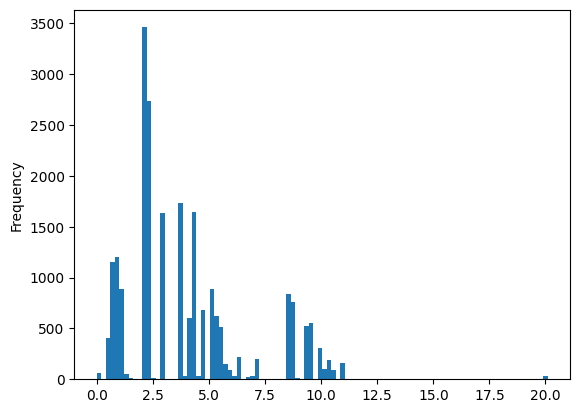

In [14]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [15]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_02FEB2016.shp                                  20.106837
Retrolens/Marlborough/WairauRiver/Shorelines/WairauRiver_07JAN2016.shp                              20.051572
Retrolens/Marlborough/CliffordBay/Shorelines/CliffordBay_07JAN2016.shp                              20.023509
Retrolens/Taranaki/Manutahi/Shorelines/Manutahi_08MAY1951.shp                                       10.936597
Retrolens/Taranaki/WainuiBeach/Shorelines/WainuiBeach_04FEB1982.shp                                 10.515310
Retrolens/Taranaki/NewPlymouth/Shorelines/NewPlymouth_14JAN2000.shp                                 10.509962
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                                   10.502980
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                                   10.483475
Retrolens/Taranaki/Onaero/Shorelines/Onaero_16SEP1958.shp                                           10.474221
R

In [16]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     6.813094
RLN    6.272558
RL     5.683750
RLS    4.916569
CRI    4.758746
Rl     3.714563
NEO    3.261561
MAX    3.099827
JIL    3.095256
PLE    3.034761
SAT    2.975786
LDS    2.358707
JIN    2.331288
Max    2.330884
max    2.273437
WV3    2.260818
PNE    2.256973
GE1    2.199101
VEX    2.162227
Name: Total_UNCY, dtype: float64

In [17]:
df.Photoscale.value_counts()

Photoscale
25000    1428
16000    1070
50000     670
44500     521
24000     443
         ... 
18850       1
8200        1
19600       1
51500       1
35100       1
Name: count, Length: 106, dtype: int64

In [18]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
2.020000    7533
0.000000    5747
3.610000    2919
4.200000    2889
5.030000    2644
5.891526     420
6.750576     410
5.891621     125
NaN           99
Name: count, dtype: int64